In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools
import warnings
import math

In [2]:
# Data processing
df = pd.read_csv('retail_clean.csv')
df = df[['Quantity', 'InvoiceDate']]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format = "%d/%m/%Y %H:%M")
df = df.set_index('InvoiceDate')
df = df.resample('M').sum()
df

C:\Users\thanh\AppData\Local\Temp\ipykernel_19940\3960478677.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').sum()


,Quantity
InvoiceDate,
2009-12-31,398708
2010-01-31,370128
2010-02-28,371871
2010-03-31,502101
2010-04-30,350604
2010-05-31,384960
2010-06-30,389880
2010-07-31,324638
2010-08-31,452551


<Axes: xlabel='InvoiceDate'>

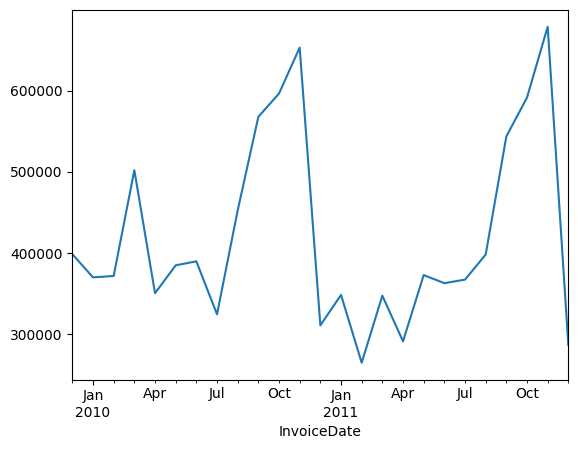

In [3]:
# Plot the mobthly quantity
monthly_data = df['Quantity']
monthly_data.plot()

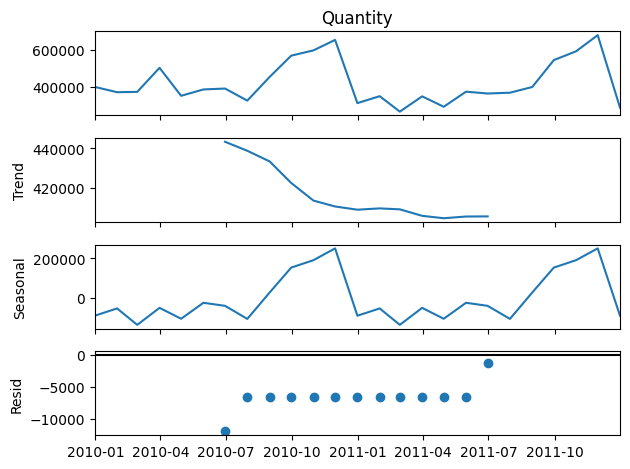

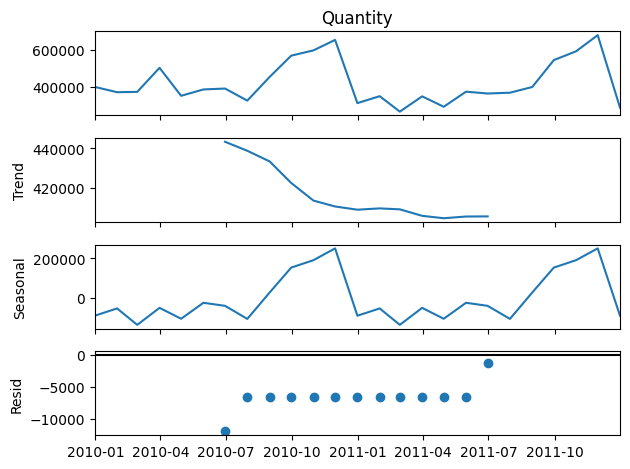

In [4]:
# Decompose trend, seasonality, remainder
demand_components = sm.tsa.seasonal_decompose(monthly_data, model='additive', period=12)
demand_components.plot()

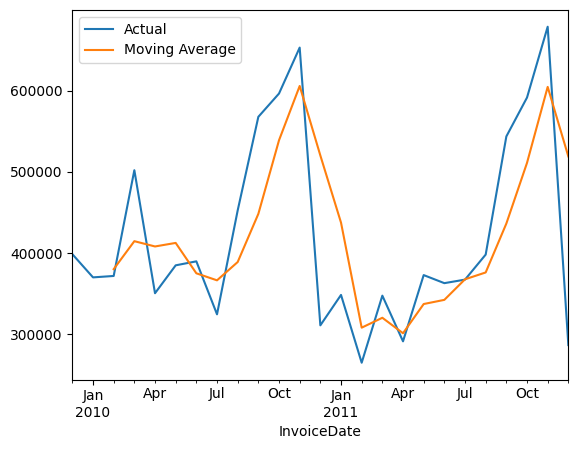

In [5]:
# Check stationary by moving average
monthly_data.plot(label='Actual')
monthly_data.rolling(window=3).mean().plot(label='Moving Average')
plt.legend()
plt.show()

In [6]:
# Adfuller test
test_adf = sm.tsa.stattools.adfuller(monthly_data, autolag = 'AIC')
test_adf[0]

np.float64(-3.356898142962889)

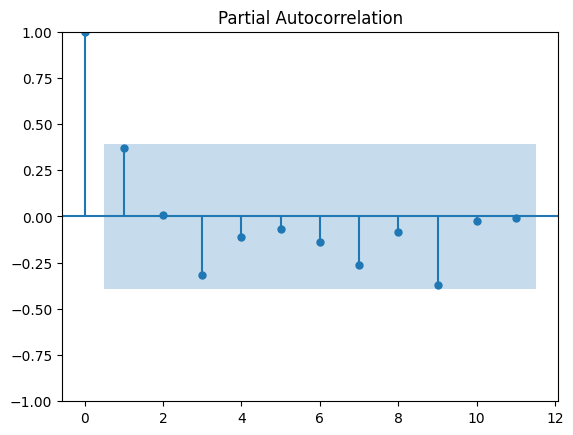

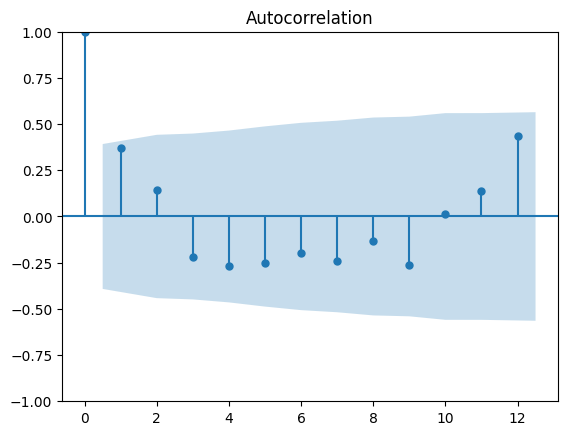

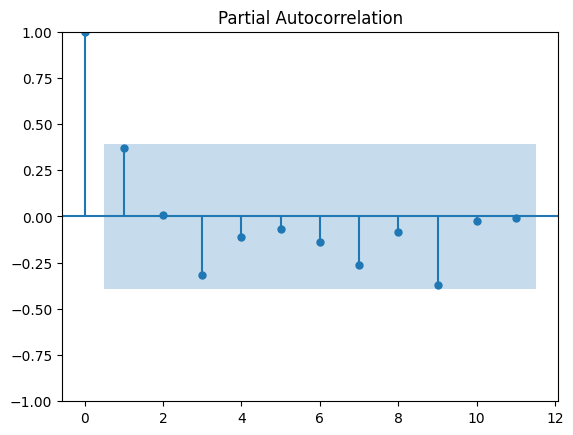

In [7]:
# ACF and PACF tests
plot_acf(monthly_data)
plot_pacf(monthly_data, lags=11)

In [8]:
# AR model
ar_model = sm.tsa.statespace.SARIMAX(monthly_data, order=(1, 0, 0))
ar_result = ar_model.fit()
ar_result.aic

np.float64(665.3244111102923)

In [9]:
# MA model
ma_model = sm.tsa.statespace.SARIMAX(monthly_data, order = (0,0,1))
ma_result = ma_model.fit()
ma_result.aic

C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


np.float64(708.0230586495464)

In [10]:
# ARMA model
arma_model = sm.tsa.statespace.SARIMAX(monthly_data, order = (1,0,1))
arma_result = arma_model.fit()
arma_result.aic

np.float64(666.2593950268389)

In [11]:
# ARIMA model
arima_model = sm.tsa.statespace.SARIMAX(monthly_data, order = (1,1,1))
arima_result = arima_model.fit()
arima_result.aic

np.float64(638.1114103614028)

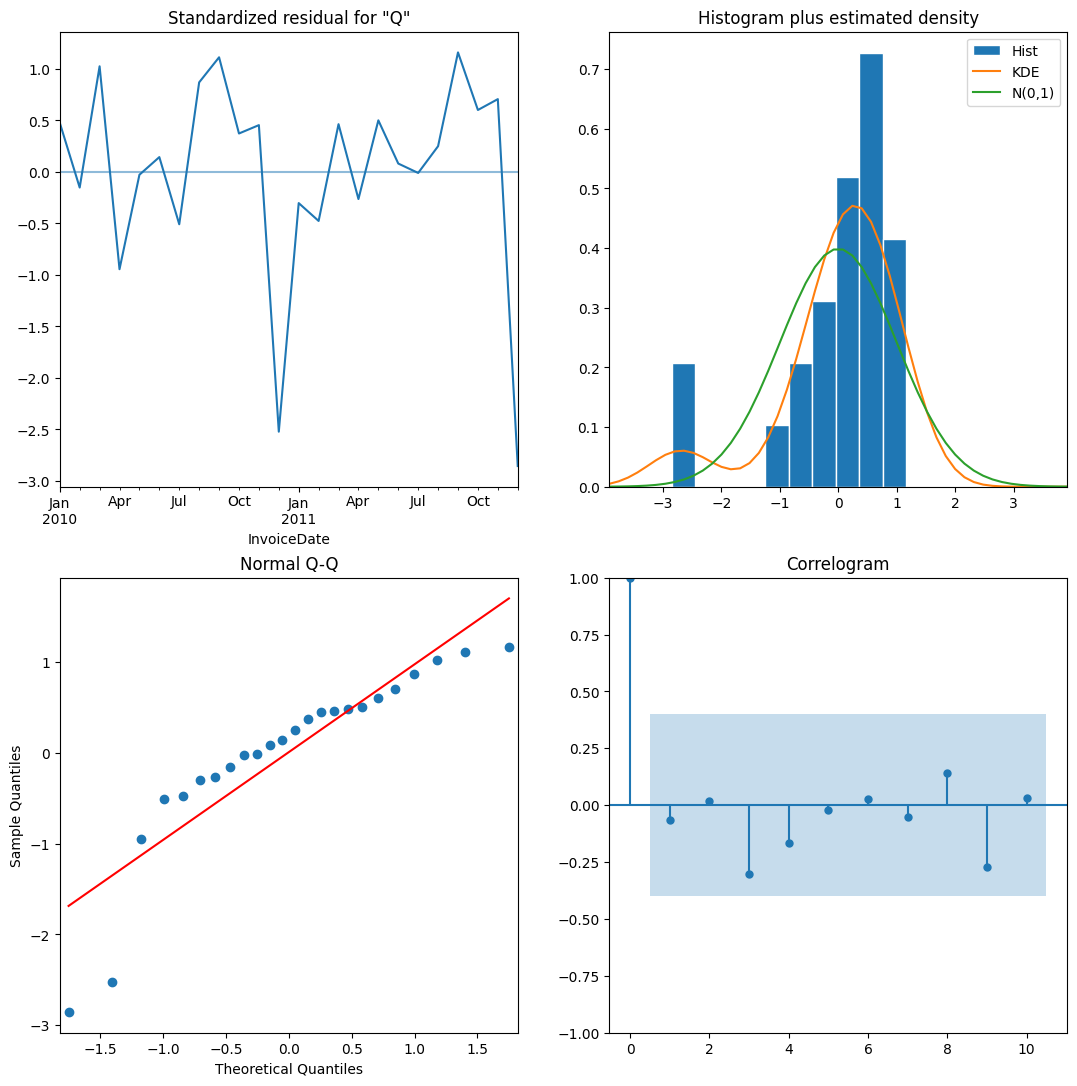

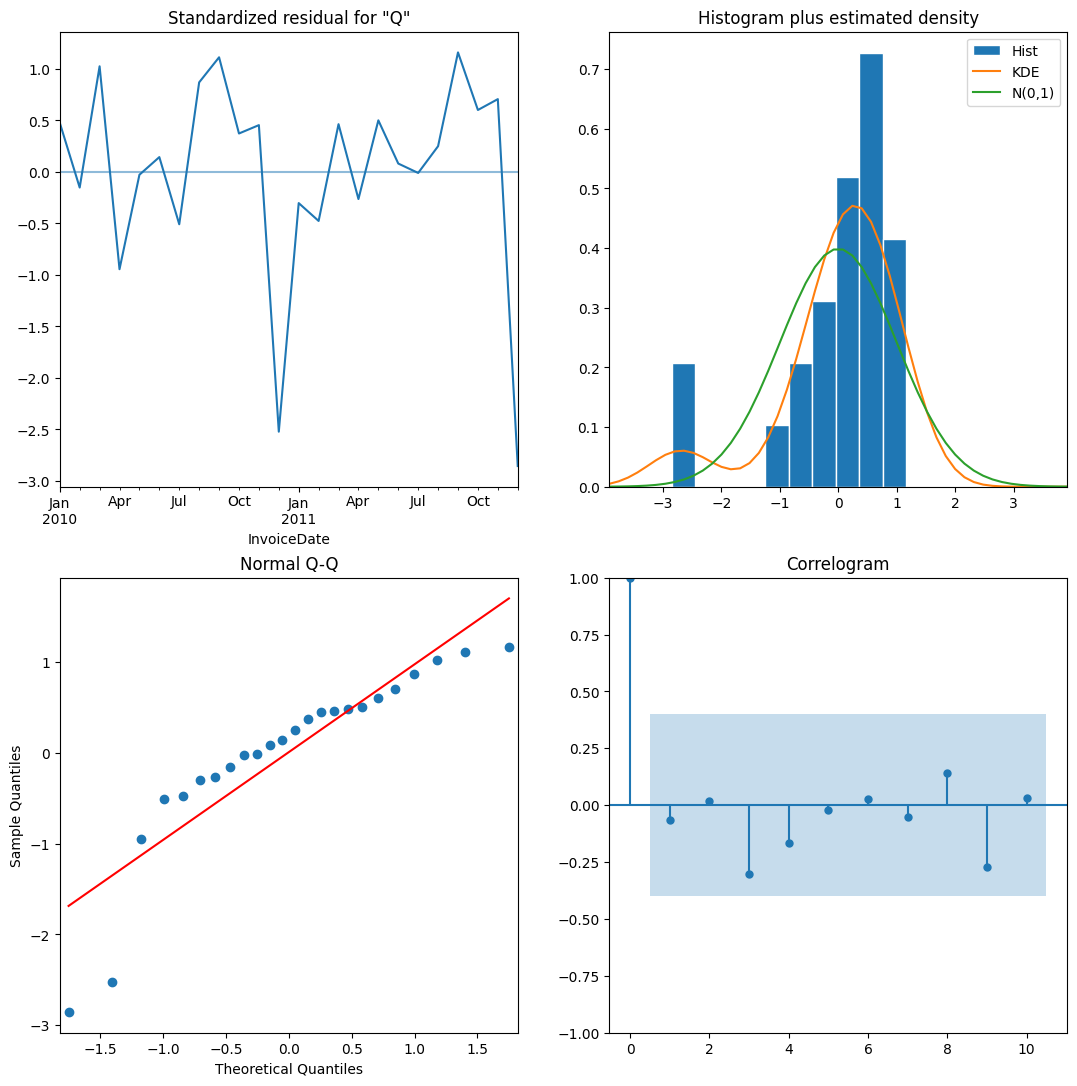

In [12]:
# Plot the ARIMA model
arima_result.plot_diagnostics(figsize=(13, 13))

In [13]:
# SARIMAX
P = D = Q = p = d = q = range(0, 3)
S = 12

combinations = list(itertools.product(p, d, q, P, D, Q))
arima_orders = [(x[0], x[1], x[2]) for x in combinations]
seasonal_orders = [(x[3], x[4], x[5], S) for x in combinations]
results_data = pd.DataFrame(columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'AIC'])

for i in range(len(combinations)):
     try:
          model = sm.tsa.statespace.SARIMAX(monthly_data, order = arima_orders[i], seasonal_order = seasonal_orders[i])
          result = model.fit()
          results_data.loc[i,'p'] = arima_orders[i][0]
          results_data.loc[i,'d'] = arima_orders[i][1]
          results_data.loc[i,'q'] = arima_orders[i][2]
          results_data.loc[i,'P'] = seasonal_orders[i][0]
          results_data.loc[i,'D'] = seasonal_orders[i][1]
          results_data.loc[i,'Q'] = seasonal_orders[i][2]
          results_data.loc[i,'AIC'] = result.aic
     except:
          continue
     
results_data[results_data.AIC == min(results_data.AIC)]

C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to e

,p,d,q,P,D,Q,AIC
87,0,1,0,0,2,0,2.0
168,0,2,0,0,2,0,2.0


 RMSE: 191502.9290613796
 MAE: 3439.5533333333406


C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


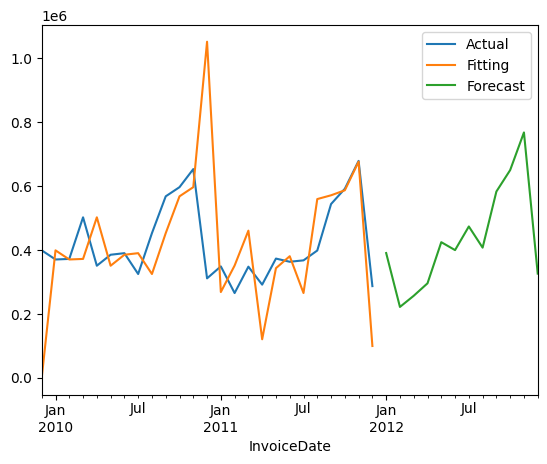

In [14]:
# Use the best model to forecast
best_model = sm.tsa.statespace.SARIMAX(monthly_data, order = (0, 1, 0), seasonal_order = (0, 2, 0, 12))
best_result = best_model.fit()

fitting = best_result.get_prediction(start = '2009-12-31')
fitting_mean = fitting.predicted_mean

forecast = best_result.get_forecast(steps = 12)
forecast_mean = forecast.predicted_mean

monthly_data.plot(label = 'Actual')
fitting_mean.plot(label = 'Fitting')
forecast_mean.plot(label = 'Forecast')
plt.legend()

# Calculate the errors
sq_error = (monthly_data - fitting_mean)**2
rmse_arima = math.sqrt(sq_error.mean())
print(f''' RMSE: {rmse_arima}''')

mae_arima = abs((monthly_data - fitting_mean).mean())
print(f''' MAE: {mae_arima}''')

In [15]:
# Exponential smoothing
expo_model_1 = ExponentialSmoothing(monthly_data, trend='add', seasonal='add', seasonal_periods=12)
expo_model_2 = ExponentialSmoothing(monthly_data, trend='add', seasonal='mul', seasonal_periods=12)
expo_model_3 = ExponentialSmoothing(monthly_data, trend='mul', seasonal='add', seasonal_periods=12)
expo_model_4 = ExponentialSmoothing(monthly_data, trend='mul', seasonal='mul', seasonal_periods=12)

# Fit the data
fit_1 = expo_model_1.fit().predict(0, len(monthly_data))
fit_2 = expo_model_2.fit().predict(0, len(monthly_data))
fit_3 = expo_model_3.fit().predict(0, len(monthly_data))
fit_4 = expo_model_4.fit().predict(0, len(monthly_data))

# Forecasting errors
mae1 = abs(monthly_data - fit_1).mean()
mae2 = abs(monthly_data - fit_2).mean()
mae3 = abs(monthly_data - fit_3).mean()
mae4 = abs(monthly_data - fit_4).mean()
print({mae1}, {mae2}, {mae3}, {mae4})

rmse1 = math.sqrt(((monthly_data - fit_1)**2).mean())
rmse2 = math.sqrt(((monthly_data - fit_2)**2).mean())
rmse3 = math.sqrt(((monthly_data - fit_3)**2).mean())
rmse4 = math.sqrt(((monthly_data - fit_4)**2).mean())
print({rmse1}, {rmse2}, {rmse3}, {rmse4})

{np.float64(24793.96636765775)} {np.float64(715158.5268709402)} {np.float64(24686.010075485174)} {np.float64(27416.132315633207)}
{36861.03753754126} {1071121.1616146977} {36617.24454913499} {37850.34942633009}


C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: Convergen

In [16]:
# Use the best model to forecast
forecast_expo3 = expo_model_3.fit().predict(0, len(monthly_data)+12)

C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


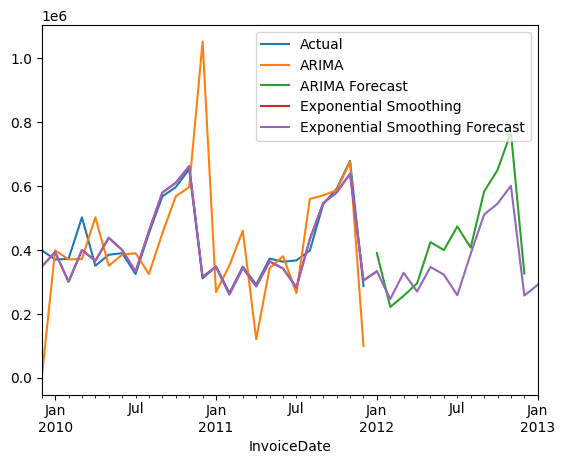

In [17]:
# Plot and compare the forecasting results
monthly_data.plot(label='Actual')
fitting_mean.plot(label='ARIMA')
forecast_mean.plot(label='ARIMA Forecast')

fit_3.plot(label='Exponential Smoothing')
forecast_expo3.plot(label='Exponential Smoothing Forecast')

plt.legend()
plt.show()